**NEXT STEPS**:

**Data wrangling**:
- ajustar el salario de USA i UK al equivalente de nivel de vida en España
- hacer drop first en todas las pd get dummies
- en age bracket y level hacer ordinal encoding (sklearn.preprocessing.OrdinalEncoder)

**Siguientes secciones:**
- Rellenar sección 3 para todas las variables que nos interesan
- Rellenar sección 4 para todas las variables que nos interesan. Dibujar histogramas o boxplot cuando vemos diferencias significativas
- Probar los métodos de reducción de dimensionalidad del notebook Dimensionality reduction
- Scaling
- Entrenar modelo (eliminar variables con colinearidad (hacer heatmap), iterar para buscar el máximo score)
- Hacer predicciones 
- Hacer readme y presentación

COMENTARIOS ALBERTO:
- antes de hacer el modelo pasar toda la matriz por standardscaler
- todas las variables categoricas tienen que estar en 0s y 1s
- pasar categoricas a 0 y 1
- si hay más de 2 categorías hacer one hot encoding
- pip install category_encoders: mejor que get dummies para proyecto final. Encoding por variables respecto a depto
- no hace falta normalizar los datos de distribución no normal, basta con hacer un test no paramétrico

# Importing libraries and data

In [1]:
from scipy import stats

import numpy as np
import pandas as pd

import seaborn as sns
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding

In [3]:
pd.options.plotting.backend = 'plotly'

In [4]:
df = pd.read_csv('project-public-clean.csv')

In [5]:
df.set_index('EEID', inplace=True)

In [6]:
df.head()

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Job Information: Date,Division,...,Supervisor EID,Pay rate,Pay rate - Currency code,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,Undergraduate degree (Grado),2019-08-19,2019-09-30,Involuntary,End of contract,2019-08-19,People,...,1,6047.0,EUR,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1
468,Inactive,29,Male,Unknown,2016-07-05,2017-03-30,Involuntary,End of contract,2016-07-05,Engineering,...,234,6144.0,EUR,Unknown,N,Unknown,No,"8 months, 25 days",0,8
458,Inactive,27,Male,Unknown,2016-09-05,2017-01-26,Involuntary,End of contract,2016-09-05,Engineering,...,0,6144.0,EUR,Unknown,N,Unknown,No,"4 months, 21 days",0,4
379,Inactive,25,Male,Undergraduate degree (Grado),2017-10-23,2018-08-28,Involuntary,End of contract,2017-10-23,Engineering,...,0,6144.0,EUR,New hire,N,Unknown,No,"10 months, 5 days",0,10
492,Inactive,58,Female,Unknown,2017-09-13,2017-09-29,Involuntary,End of contract,2017-09-13,People,...,0,7200.0,EUR,Unknown,N,Unknown,No,16 days,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 343 to 721
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Status                      607 non-null    object 
 1   Age                         607 non-null    int64  
 2   Gender                      607 non-null    object 
 3   Education Level             607 non-null    object 
 4   Hire Date                   607 non-null    object 
 5   Termination Date            258 non-null    object 
 6   Termination Type            258 non-null    object 
 7   Termination Reason          254 non-null    object 
 8   Job Information: Date       607 non-null    object 
 9   Division                    607 non-null    object 
 10  Department                  607 non-null    object 
 11  Supervisor EID              607 non-null    int64  
 12  Pay rate                    607 non-null    float64
 13  Pay rate - Currency code    607 n

# Data wrangling

In [8]:
df['Attrition'] = pd.get_dummies(df['Termination Type'], drop_first=True)

In [9]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'USD', df['Pay rate'] * 0.82, df['Pay rate'])
# también funcionaría con lo siguiente, pero me queda mas claro usando np.where: df.apply(lambda x: (x['Pay rate'] * 0.82) if x['Pay rate - Currency code'] == 'USD' else x['Pay rate'], axis=1)

In [10]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'GBP', df['Pay rate'] * 1.16, df['Pay rate EUR'])

In [11]:
# Para comprobar que está bien:
df[['Pay rate', 'Pay rate - Currency code', 'Pay rate EUR']][df['Pay rate - Currency code'] == 'GBP']

,Pay rate,Pay rate - Currency code,Pay rate EUR
EEID,,,
700,41600.0,GBP,48256.0
697,44000.0,GBP,51040.0
779,44000.0,GBP,51040.0
698,56000.0,GBP,64960.0
774,68000.0,GBP,78880.0
757,68000.0,GBP,78880.0
731,96000.0,GBP,111360.0
161,99200.0,GBP,115072.0


In [12]:
# Location
df['Location'] = df.apply(lambda x: 'North America' if x['Pay rate - Currency code'] == 'USD' else 'Europe', axis=1)

In [13]:
# Reordenamos las columnas para que quede más claro:
df = df[['Status', 'Age', 'Gender', 'Education Level', 'Hire Date', 
       'Termination Date', 'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department', 'Supervisor EID',
       'Pay rate', 'Pay rate - Currency code', 'Pay rate EUR', 'Compensation Change Reason',
       'Stock Options', 'Level', 'Is Supervisor', 'Length of service',
       'Length of service: Years', 'Length of service: Months']]

In [14]:
df['Age bracket'] = pd.cut(df['Age'], bins = [18, 25, 30, 35, 40, 45, 50, 55]) #, labels = ['18-25','26-30','31-35','36-40','41-45','46-50','51+'])

In [15]:
df['Division'] = df['Division'].apply(lambda x: 'People & Home' if 'People' in x or 'Home' in x else x)

In [16]:
df['Division'] = df['Division'].apply(lambda x: 'Finance & Legal' if 'Finance' in x else x)

In [17]:
df['Division'] = df['Division'].apply(lambda x: 'Leadership' if 'Founders' in x else x)

In [18]:
df.groupby('Division').sum()['Attrition'] / df.groupby('Division').count()['Attrition']

Division
Business Development    0.294118
Customer Success        0.233766
Data & Analytics        0.228070
Design                  0.272727
Engineering             0.382775
Finance & Legal         0.272727
Leadership              0.333333
Marketing               0.327586
People & Home           0.272727
Product                 0.400000
R&D                     0.000000
Security                0.000000
Strategy                0.000000
Unknown                 0.333333
Name: Attrition, dtype: float64

In [19]:
df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1)

In [20]:
df.drop(df.loc[df['Not Specified'] == 1].index, inplace=True)

In [21]:
df.drop(df.loc[df['Unknown'] == 1].index, inplace=True)

In [22]:
df = df.drop(columns=['Male', 'Not Specified', 'Unknown'])

In [23]:
df.drop('Education Level', axis=1, inplace=True)

In [24]:
df['North America'] = pd.get_dummies(df['Location'], drop_first=True)

In [25]:
df.Division.value_counts()

Engineering             207
Customer Success         76
Marketing                58
Data & Analytics         57
People & Home            54
Design                   44
Product                  40
Finance & Legal          22
Business Development     17
Strategy                 11
Security                  8
R&D                       3
Leadership                3
Unknown                   3
Name: Division, dtype: int64

In [26]:
df = pd.concat([df, pd.get_dummies(df['Division'])], axis=1)

In [27]:
df.drop(df.loc[df['Unknown'] == 1].index, inplace=True)

In [28]:
df = df.drop(columns=['Unknown'])

In [29]:
df['Has_stock'] = pd.get_dummies(df['Stock Options'], drop_first=True)

In [30]:
df['Level'].value_counts()
# muchos valores unknown!

E3         157
E2         135
Unknown     66
M1          44
L2          43
L3          30
M3          28
M2          21
E4          20
E1          20
C-Level      7
L1           7
E0           6
L4           5
M4           5
E5           2
L0           1
E6           1
M0           1
L5           1
Name: Level, dtype: int64

In [31]:
df['Level'] = df['Level'].replace('(.*)[^EM](?=\d)','E', regex=True)

In [32]:
df = pd.concat([df, pd.get_dummies(df['Level'])], axis=1)

In [33]:
df.rename(columns={'Unknown':'Unknown_level'}, inplace=True)

In [34]:
df['Is_Supervisor_enc'] = pd.get_dummies(df['Is Supervisor'], drop_first=True)

In [35]:
df.columns

Index(['Status', 'Age', 'Gender', 'Hire Date', 'Termination Date',
       'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department',
       'Supervisor EID', 'Pay rate', 'Pay rate - Currency code',
       'Pay rate EUR', 'Compensation Change Reason', 'Stock Options', 'Level',
       'Is Supervisor', 'Length of service', 'Length of service: Years',
       'Length of service: Months', 'Age bracket', 'Female', 'North America',
       'Business Development', 'Customer Success', 'Data & Analytics',
       'Design', 'Engineering', 'Finance & Legal', 'Leadership', 'Marketing',
       'People & Home', 'Product', 'R&D', 'Security', 'Strategy', 'Has_stock',
       'C-Level', 'E0', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'M0', 'M1', 'M2',
       'M3', 'M4', 'Unknown_level', 'Is_Supervisor_enc'],
      dtype='object')

In [79]:
df

,Status,Age,Gender,Attrition,Location,Division,Pay rate,Pay rate - Currency code,Stock Options,Level,...,L3,L4,L5,M0,M1,M2,M3,M4,Unknown_level,Is_Supervisor_enc
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,0,Europe,People & Home,6047.0,EUR,N,Unknown,...,0,0,0,0,0,0,0,0,1,0
468,Inactive,29,Male,0,Europe,Engineering,6144.0,EUR,N,Unknown,...,0,0,0,0,0,0,0,0,1,0
458,Inactive,27,Male,0,Europe,Engineering,6144.0,EUR,N,Unknown,...,0,0,0,0,0,0,0,0,1,0
379,Inactive,25,Male,0,Europe,Engineering,6144.0,EUR,N,Unknown,...,0,0,0,0,0,0,0,0,1,0
492,Inactive,58,Female,0,Europe,People & Home,7200.0,EUR,N,Unknown,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,Inactive,35,Female,1,North America,Product,211200.0,USD,N,Unknown,...,0,0,0,0,0,0,0,0,1,0
760,Active,47,Female,0,North America,R&D,220000.0,USD,N,M3,...,0,0,0,0,0,0,1,0,0,1
773,Active,40,Male,0,North America,Marketing,220000.0,USD,N,M4,...,0,0,0,0,0,0,0,1,0,0


# Exploratory Data Analysis (plots y shapiro tests)

Variable que queremos predecir: **Attrition**

Variables que nos interesan: 

**Numéricas:**
- Age
- Pay rate EUR
- Lenghts of service (months)

**Categóricas:**
- Gender
- Education Level? muchos unknowns
- Location
- Division
- Stock Options
- Level? Bastantes unknowns
- Is Supervisor
- Age bracket

**Columnas encoded**: 'Female', 'North America', 'Business Development', 'Customer Success',
       'Data & Analytics', 'Design', 'Engineering', 'Finance & Legal',
       'Leadership', 'Marketing', 'People & Home', 'Product', 'R&D',
       'Security', 'Strategy', 'Has_stock', 'C-Level', 'E0', 'E1', 'E2', 'E3',
       'E4', 'E5', 'E6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'M0', 'M1', 'M2',
       'M3', 'M4', 'Unknown_level', 'Is_Supervisor_enc'


In [35]:
cols_to_drop = ['Hire Date', 'Termination Date', 'Termination Type', 'Termination Reason', 'Job Information: Date',
                'Department', 'Supervisor EID', 'Pay rate', 'Compensation Change Reason', 'Length of service', 
                'Length of service: Years', 'Age bracket']
# borro las columnas que no vamos a usar

In [36]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [37]:
df.columns

Index(['Status', 'Age', 'Gender', 'Education Level', 'Attrition', 'Location',
       'Division', 'Pay rate', 'Pay rate - Currency code', 'Stock Options',
       'Level', 'Is Supervisor', 'Length of service: Months', 'Female',
       'North America', 'Business Development', 'Customer Success',
       'Data & Analytics', 'Design', 'Engineering', 'Finance & Legal',
       'Leadership', 'Marketing', 'People & Home', 'Product', 'R&D',
       'Security', 'Strategy', 'Has_stock', 'C-Level', 'E0', 'E1', 'E2', 'E3',
       'E4', 'E5', 'E6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'M0', 'M1', 'M2',
       'M3', 'M4', 'Unknown_level', 'Is_Supervisor_enc'],
      dtype='object')

In [38]:
# columnas encoded: df.columns[-37:]

In [39]:
stats.shapiro(df['Age'])

ShapiroResult(statistic=0.9510449767112732, pvalue=3.2900795260935867e-13)

In [40]:
stats.shapiro(df['Pay rate'])

ShapiroResult(statistic=0.6854991316795349, pvalue=6.709302103010374e-32)

In [42]:
# tiene sentido hacerlo con todo el histórico o mejor por años?
# df['Involuntary'], df['Voluntary'] = pd.get_dummies(df['Termination Type'])

# Hypothesis testing (t-test, Chi2)

## Does division afect attrition?

In [43]:
df_chi = pd.DataFrame(df.groupby('Division').sum()['Attrition'])

In [44]:
df_chi['Not_Attrition'] = df.groupby('Division').count()['Attrition'] - df_chi['Attrition']

In [45]:
df_chi

,Attrition,Not_Attrition
Division,,
Business Development,5,12
Customer Success,18,58
Data & Analytics,13,44
Design,12,32
Engineering,80,127
Finance & Legal,6,16
Leadership,1,2
Marketing,19,39
People & Home,15,39


In [46]:
stats.chi2_contingency(df_chi)
# p-value muy cerca de 0.05

(21.60747890482076,
 0.04216186344743516,
 12,
 array([[  5.2417,  11.7583],
        [ 23.4333,  52.5667],
        [ 17.575 ,  39.425 ],
        [ 13.5667,  30.4333],
        [ 63.825 , 143.175 ],
        [  6.7833,  15.2167],
        [  0.925 ,   2.075 ],
        [ 17.8833,  40.1167],
        [ 16.65  ,  37.35  ],
        [ 12.3333,  27.6667],
        [  0.925 ,   2.075 ],
        [  2.4667,   5.5333],
        [  3.3917,   7.6083]]))

In [47]:
df_chi.iplot('bar') # esto debería ir en el apartado anterior

## Does salary affect attrition?

In [48]:
stats.shapiro(df['Pay rate'])
# distribución de salarios no normal
# tenemos que hacer t-test o wilcoxon? Para hacer paramétrico, necesitamos que Attrition tenga distribución normal, o Pay rate?

ShapiroResult(statistic=0.6854991316795349, pvalue=6.709302103010374e-32)

In [56]:
not_attrition = df[df['Attrition'] == 0]
attrition = df[df['Attrition'] == 1]

In [60]:
stats.ttest_ind(not_attrition['Pay rate EUR'], attrition['Pay rate EUR'])

Ttest_indResult(statistic=1.814044942170215, pvalue=0.07017183596672942)

In [59]:
stats.mannwhitneyu(not_attrition['Pay rate EUR'], attrition['Pay rate EUR'])
# p-value muy bajo, rechazamos H0 y aceptamos que el salario tiene influencia en la Attrition

MannwhitneyuResult(statistic=34909.5, pvalue=0.03805375665587643)

In [51]:
df['Pay rate'].iplot('hist')

In [52]:
df[['Division', 'Pay rate']].pivot(columns='Division', values='Pay rate EUR').iplot(kind='box')

# Dimensionality reduction - t-SNE

In [41]:
from sklearn.preprocessing import LabelEncoder

In [44]:
df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 343 to 721
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        600 non-null    int64  
 1   Attrition                  600 non-null    uint8  
 2   Supervisor EID             600 non-null    int64  
 3   Pay rate                   600 non-null    float64
 4   Pay rate EUR               600 non-null    float64
 5   Length of service: Years   600 non-null    int64  
 6   Length of service: Months  600 non-null    int64  
 7   Female                     600 non-null    uint8  
 8   North America              600 non-null    uint8  
 9   Business Development       600 non-null    uint8  
 10  Customer Success           600 non-null    uint8  
 11  Data & Analytics           600 non-null    uint8  
 12  Design                     600 non-null    uint8  
 13  Engineering                600 non-null    uint8

In [45]:
help(TSNE())

Help on TSNE in module sklearn.manifold._t_sne object:

class TSNE(sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None, square_distances='legacy')
 |  
 |  t-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
 |

In [53]:
tt = TSNE(n_components=2, random_state=0, perplexity=20).fit_transform(df.select_dtypes('number'))

In [54]:
tt.shape

(600, 2)

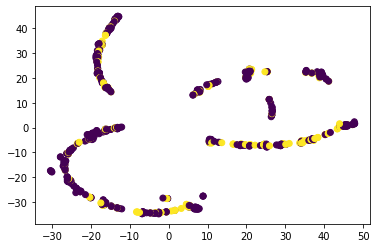

In [55]:
plt.scatter(tt[:,0], tt[:,1], c=LabelEncoder().fit_transform(df['Attrition']))

# BORRAR - PCA Decomposition

In [ ]:
df_num = df.select_dtypes('number')

In [77]:
pca = decomposition.PCA()

NameError: name 'decomposition' is not defined

In [ ]:
pca.fit(df_num)

In [ ]:
pca.components_.shape

In [ ]:
df_num.info()

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca = decomposition.PCA(n_components=2)

In [ ]:
pca.fit(df_num)

In [ ]:
pca.components_.shape

In [ ]:
plt.figure(figsize=(20,4))
sns.heatmap(pd.DataFrame(pca.components_, index=['pc1', 'pc2'], columns=df_num.columns), annot=True, cmap='coolwarm', center=0)

# Preprocessing: scaling (+ otras cosas?)

# Training model

# Prediction